In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import re
from thefuzz import fuzz
from thefuzz import process
import requests
import json
import sys
from wordcloud import WordCloud

In [3]:
# Load data
data = pd.read_csv('./Natural language processing/analytics_allmode_midlevel_fulltime.csv')

I. Data Cleaning & EDA

In [4]:
# check missing data
data.isna().sum() / len(data)

title       0.001994
comp        0.004985
loc         0.004320
postdate    0.004320
desc        0.518112
numapp      0.517115
industry    0.284812
desc2       0.231306
workmode    0.000000
dtype: float64

In [5]:
# clean missing data
data = data.dropna(subset=['title', 'comp', 'loc'])
data.isna().sum() / len(data)

data = data.drop('desc', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2993 entries, 0 to 3008
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     2993 non-null   object
 1   comp      2993 non-null   object
 2   loc       2993 non-null   object
 3   postdate  2993 non-null   object
 4   numapp    1452 non-null   object
 5   industry  2152 non-null   object
 6   desc2     2312 non-null   object
 7   workmode  2993 non-null   object
dtypes: object(8)
memory usage: 210.4+ KB


In [6]:
# check unwanted characters in data
data.head()

,title,comp,loc,postdate,numapp,industry,desc2,workmode
0,"\n \n Senior Data Analyst, Amazon\n \n",\n Harry's Inc.\n,"\n New York, NY\n",\n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \n...,\n Over 200 applicants\n,\n Manufacturing\n,About Harry’s\n\nHarry’s Inc. started in 2013 ...,Hybrid
1,\n \n Business Intelligence Lead\n \n,\n Little Caesars Pizza\n,\n Detroit Metropolitan Area\n,\n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \n...,NaN,Restaurants\n,"Build a Bigger, Better, Bolder Future\n\nImagi...",Hybrid
2,"\n \n Sr. Analyst, Digital Analytics \n \n",\n Grubhub\n,\n New York City Metropolitan Area\n,\n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \n...,\n Over 200 applicants\n,Technology\n,About The Opportunity\n\nWe’re all about conne...,Hybrid
3,\n \n Senior Data Analyst\n \n,\n Evite\n,"\n Glendale, CA\n",\n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \n...,NaN,NaN,NaN,Hybrid
4,"\n \n Senior Manager, Business Intelligence\n \n",\n National Football League (NFL)\n,"\n New York, NY\n",\n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \n...,NaN,NaN,NaN,Hybrid


In [7]:
# define a function to remove unwanted characters
def remove_char(string):
    return re.sub('\n', '', string)

In [8]:
# remove unwanted characters
for column in data.columns:
    data[column] = data[column].astype(str)
    data[column] = data[column].apply(remove_char)

data = data.replace({'nan': None})

In [9]:
# check data after removing unwanted characters
data.head()

,title,comp,loc,postdate,numapp,industry,desc2,workmode
0,"Senior Data Analyst, Amazon",Harry's Inc.,"New York, NY",3 weeks ago,Over 200 applicants,Manufacturing,About Harry’sHarry’s Inc. started in 2013 with...,Hybrid
1,Business Intelligence Lead,Little Caesars Pizza,Detroit Metropolitan Area,5 days ago,None,Restaurants,"Build a Bigger, Better, Bolder FutureImagine w...",Hybrid
2,"Sr. Analyst, Digital Analytics",Grubhub,New York City Metropolitan Area,4 weeks ago,Over 200 applicants,Technology,About The OpportunityWe’re all about connectin...,Hybrid
3,Senior Data Analyst,Evite,"Glendale, CA",1 month ago,None,None,None,Hybrid
4,"Senior Manager, Business Intelligence",National Football League (NFL),"New York, NY",1 day ago,None,None,None,Hybrid


In [10]:
# delete duplicates as a remote job might be posted across US cities
remote_dedup = data[data['workmode'] == 'Remote'].drop_duplicates(['title', 'comp'])

# delete duplicates as a job might be re-posted multiple times
noremote_dedup = data[data['workmode'] != 'Remote'].drop_duplicates(['title', 'comp', 'loc'])

data = pd.concat([noremote_dedup, remote_dedup])
print(data.shape)

(2583, 8)


In [11]:
# delete unrelevant job posts
pm = data['title'].str.contains('Product Manager')
data = data[~pm]
print(data.shape)

(2513, 8)


II. Analysis

In [63]:
# set up a default style for visuals
sns.set_style('white') 
sns.color_palette('viridis')
plt.rc('font', family='Segoe UI')  # Set global font to 'Segoe UI'
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('font', size=14)          # controls default text sizes

In [13]:
# prepare for title cleaning
# get unique categories from title
# define function 
def extract_cat(string, threshold):
    clean_titles = []
    for s in string:
        if not clean_titles:
            clean_titles.append(s)
        else:
            highest_sim = process.extractOne(s, clean_titles, scorer=fuzz.ratio)[1]
            if highest_sim < threshold:
                clean_titles.append(s)
    return clean_titles

In [14]:
# prepare for title cleaning
toptitles = data['title'].value_counts()[:100].index
cleantitles = extract_cat(toptitles, 80)
print(cleantitles)

Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '"']


['  Data Scientist ', '  Senior Data Analyst ', '  Business Analyst ', '  Business Intelligence Analyst ', '  Analytics Manager ', '  Business Intelligence Developer ', '  Consultant - Business Operations / Management ', '  Data Analyst ', '  Marketing Data Analyst ', '  Senior Financial Analyst ', '  Product Analyst ', '  BI Developer ', '  Senior Analytics Engineer ', '  Strategy and Planning Senior Program Manager ', '  Business Intelligence - Planning and Strategy Manager ', '  Business Analytics Manager ', '  Lead Analytics Consultant ', '  Growth Marketing Manager ', '  Healthcare Data Analyst ', '  Data Engineer ', '  Manager, Strategic Analytics Services ', '  Manager, Data Analytics ', '  Senior Analytics Specialist, Marketing ', '  Power BI/Data Analyst ', '  Consumer Insights Manager ', '  Financial Data Analyst ', '  Senior Manager, Analytics ', '  Paid Search Analyst ', '  Marketing Analytics Manager ', '  Data Science Manager ', '  Data Manager ', '  Strategy and Operatio

In [15]:
# clean titles using record linkage
cleantitles = ['  Analytics Manager ', '  Business Intelligence Manager ', '  Data Analyst ', '  Data Scientist ', '  Business Analyst ', '  Consultant ', '  Business Intelligence Analyst ', '  Product Analyst ', '  BI Developer ', '  Analytics Engineer ', '  Analytics Specialist', '  Data Engineer ', '  Power BI Analyst ', '  Analytics and Insights Manager ', '  Data Science Manager ', '  Machine Learning Engineer ', '  Strategy and Operations Manager ', '  Tableau Developer ', '  Data Visualization Engineer ',  '  Data Manager ', ' Artificial Intelligence Manager ', '  Reporting Analyst ']

# unique titles in data set
uniquetitles = data.title.unique()

# identify cut off points
for t in cleantitles:
    print(t, '\n', process.extract(t, uniquetitles, limit=len(uniquetitles)))


  Analytics Manager  
 [('  Analytics Manager ', 100), ('  ANALYTICS MANAGER ', 100), ('  People Analytics Manager ', 95), ('  Senior Manager, Analytics ', 95), ('  Manager, Data & Analytics ', 95), ('  Senior Manager Analytics ', 95), ('  Senior Analytics Manager ', 95), ('  Data & Analytics Manager ', 95), ('  Manager Data Analytics ', 95), ('  Manager, Data Analytics ', 95), ('  Data Analytics Manager  ', 95), ('  Manager, Analytics ', 95), ('  Manager, Client Analytics ', 95), ('  Sales Analytics Manager ', 95), ('  Data Analytics Manager ', 95), ('  Manager, Sales Analytics ', 95), ('  Sr. Manager, HR Analytics ', 95), ('  BI Analytics Manager ', 95), ('  Finance Analytics Manager ', 95), ('  Growth Analytics Manager ', 95), ('  Pricing Analytics Manager ', 95), ('  Manager of Web Analytics ', 95), ('  Sr. Manager - Analytics ', 95), ('  Sr. Manager, Analytics ', 95), ('  Manager of Analytics ', 95), ('  Churn Analytics Manager ', 95), ('  Manager, OPO Analytics ', 95), ('  Manage

  Machine Learning Engineer  
 [('  Machine Learning Engineer ', 100), ('  BI Engineer ', 86), ('  Data Engineer ', 86), ('  Lead BI Engineer ', 86), ('  Manager Predictive Analytics & Machine Learning ', 86), ('  Nuuly Senior Business Intelligence Engineer ', 86), ('  Senior Data Engineer: New York, NY, San Francisco, CA ', 86), ('  Sr Data Engineer ', 86), ('  Project Manager/Software Engineer - Data Science - Machine Learning ', 86), ('  Remote Work - Need Lead Business Intelligence Engineer ', 86), ('  Senior Analytics Engineer - Remote, US ', 86), ('  Senior Manager, Machine Learning ', 75), ('  AI Lead ', 64), ('  Analytics Engineer ', 60), ('  Lead Power BI Engineer ', 60), ('  Senior BI Engineer ', 58), ('  Data Analytics Engineer ', 58), ('  Lead Analytics Engineer ', 58), ('  Chief Marketing Officer ', 58), ('  Manager of Data Engineering and Analytics ', 58), ('  Business Intelligence Engineer ', 58), ('  Business Intelligence Engineer  ', 58), ('  Lead Data Engineer - Gamin

In [34]:
# assign unclean titles to clean titles
for ct in cleantitles:
    matches = process.extract(ct, data['title'], limit=len(data['title']))
    for m in matches:
        if m[1] >= 90:
            data['title'].loc[data['title'] == m[0]] = ct 

C:\Users\vanvi\AppData\Local\Temp\ipykernel_27568\4140930344.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1. Top roles in demand

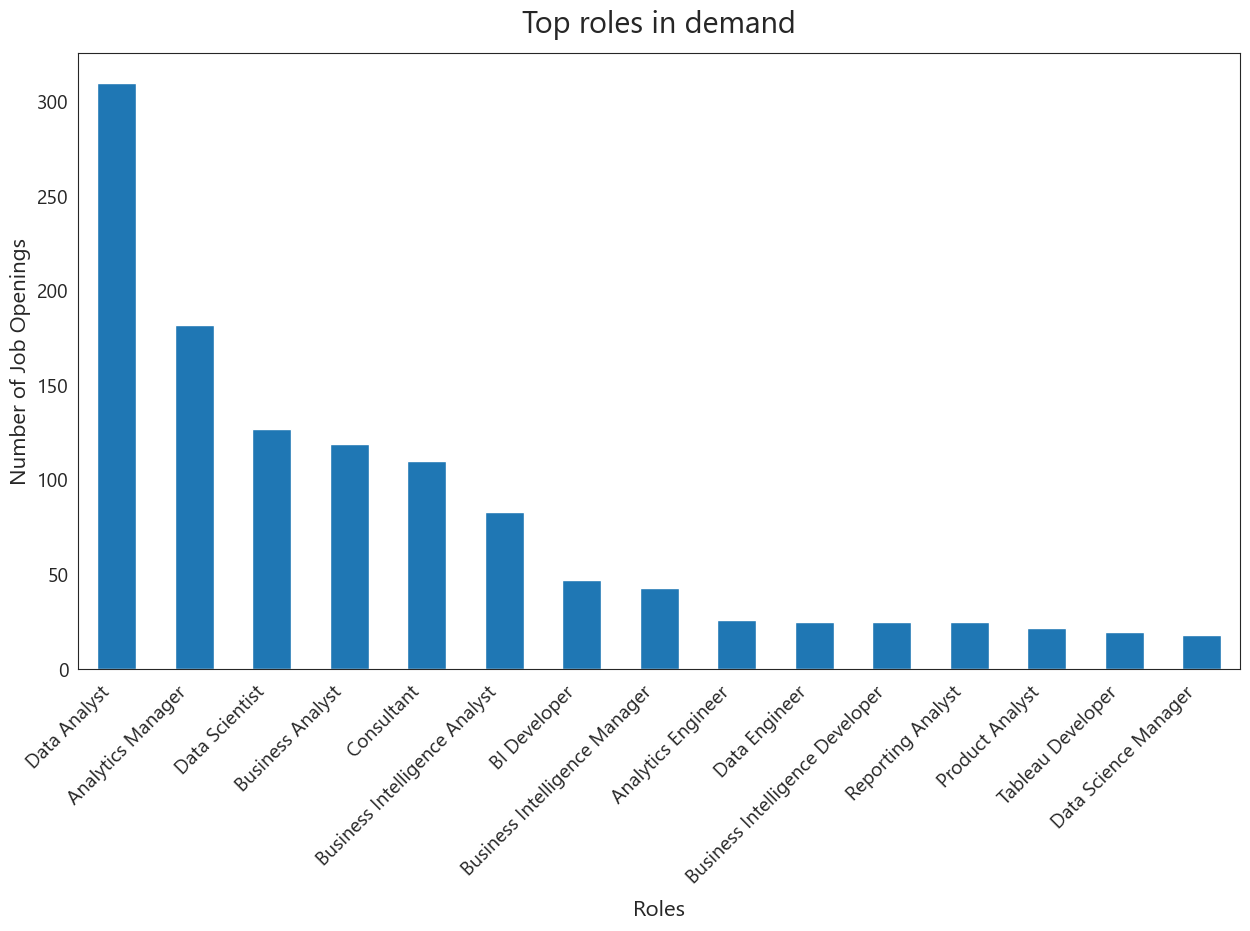

In [36]:
# top roles in demand
top15 = data['title'].value_counts()[:15]

plt.figure(figsize=(15,8))
top15.plot(kind='bar')
plt.xlabel('Roles')
plt.ylabel('Number of Job Openings')
plt.title('Top roles in demand', y = 1.02)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

2. If the jobs are onsite or hybrid, where are they based?

In [17]:
# clean location data
data[['city', 'state']] = data['loc'].str.split(',', expand=True)

data['state'] = data['state'].fillna(data['city']) # fill null with value from city
data['state'] = data['state'].str.strip() # remove trailing space created due to the split

# find the nasty state names
df = data[data['state'].str.len() >=3]
df.state.unique()

# create a mapping dict to clean state column to contain only abbreviated states
mappingdict = {
    'Detroit Metropolitan Area': 'MI',
    'New York City Metropolitan Area': 'NY',
    'Los Angeles Metropolitan Area': 'CA',
    'San Francisco Bay Area': 'CA',
    'Dallas-Fort Worth Metroplex': 'TX',
    'Greater St. Louis': 'MO',
    'Texas Metropolitan Area': 'TX',
    'Greater Pittsburgh Region': 'PA',
    'Greater Boston': 'MA',
    'Charlotte Metro': 'NC',
    'Greater Seattle Area': 'WA',
    'Greater Chicago Area': 'IL',
    'Ohio Metropolitan Area': 'OH',
    'Greater Sacramento': 'CA',
    'Miami-Fort Lauderdale Area': 'FL',
    'Greater Phoenix Area': 'AZ',
    'Atlanta Metropolitan Area': 'GA',
    'Greater Orlando': 'FL',
    'Denver Metropolitan Area': 'CO',
    'Oregon Metropolitan Area': 'OR',
    'Greater Philadelphia': 'PA',
    'Cincinnati Metropolitan Area': 'OH',
    'Washington DC-Baltimore Area': 'DC',
    'Urbana-Champaign Area': 'IL',
    'Chicago metropolitan area': 'IL',
    'Grand Rapids Metropolitan Area': 'MI',
    'San Diego Metropolitan Area': 'CA',
    'Kansas City Metropolitan Area': 'MO',
    'Greater Houston': 'TX',
    'Nashville Metropolitan Area': 'TN',
    'Greater Palm Bay-Melbourne-Titusville Area': 'FL',
    'Greater Macon': 'GA',
    'Wisconsin Metropolitan Area': 'WI',
    'Louisville Metropolitan Area': 'KY'
}

# clean up nasty state names
data['state'] = data['state'].replace(mappingdict)

print(data.state.unique())

['NY' 'MI' 'CA' 'MA' 'TX' 'GA' 'NJ' 'United States' 'CT' 'DC' 'FL' 'DE'
 'RI' 'MD' 'AZ' 'OH' 'NM' 'IL' 'TN' 'IN' 'PA' 'NC' 'OR' 'MO' 'VA' 'NH'
 'WA' 'AR' 'SC' 'CO' 'MN' 'SD' 'WI' 'ID' 'OK' 'UT' 'NE' 'HI' 'KY' 'NV'
 'MS' 'IA' 'KS' 'ME' 'LA' 'AL' 'ND' 'VT']


In [18]:
# jobs that are hybrid or onsite
noremote = data[(data.workmode != 'Remote') & (data.state != 'United States')]

jobcounts = noremote.state.value_counts()
print(jobcounts)

state
CA    298
NY    194
TX    168
IL    108
FL    102
MA    100
GA     83
NC     68
NJ     66
VA     63
PA     54
OH     48
DC     46
AZ     35
TN     34
MI     31
CO     30
MD     26
MN     22
WA     21
MO     20
IN     14
IA     14
AR     14
CT     13
OR     12
UT     12
DE     11
SC     11
WI     10
KY      9
NV      7
AL      7
NE      6
ID      5
OK      4
LA      3
MS      3
RI      3
HI      3
NM      2
KS      2
ME      2
NH      2
SD      2
VT      2
ND      1
Name: count, dtype: int64


In [21]:
# if the jobs are onsite or hybrid, where are they based?
fig = px.choropleth(locations= jobcounts.index, locationmode='USA-states', scope='usa',
              color=jobcounts.values, color_continuous_scale='Viridis_r')

fig.update_layout(
      title_text = 'Feb 2024 Number of Onsite/Hybrid Job Openings by Locations',
      title_font_family="Segoe UI",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )

fig.show()

3. What industry is leading the hiring?

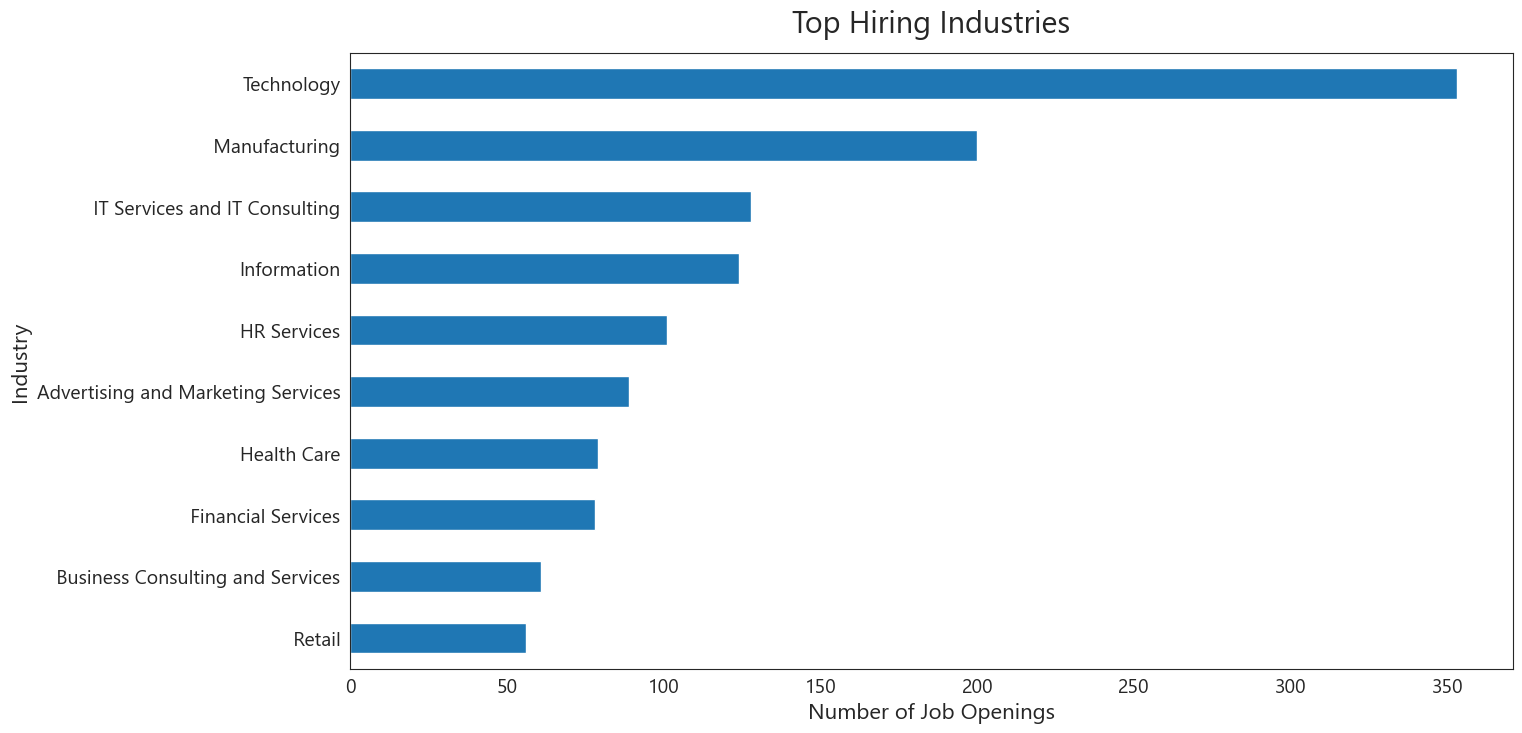

In [19]:
# top industries are hiring
topind = data['industry'].value_counts()[:10]

plt.figure(figsize = (15,8))
topind.sort_values().plot(kind='barh')
plt.title('Top Hiring Industries', y = 1.02)
plt.ylabel('Industry')
plt.xlabel('Number of Job Openings')
plt.show()


4. Skills desired

In [31]:
# prepare for running Skill Extractor API which limits document size each run
# check size in bytes of the agg description
def getsize(text):
    return (sys.getsizeof(text))
descsize = aggdesc.apply(getsize)
print(descsize)

# cut string to 50KB
def cut_string_to_50k(s):
    max_bytes = 50 * 1024  # 50kb in bytes
    while sys.getsizeof(s) > max_bytes:
        s = s[:-1]  # Remove the last character
    return s

aggdesc_50k = aggdesc.apply(cut_string_to_50k)

# sanity check
print(aggdesc_50k.apply(getsize))


title
  Analytics Engineer                  90976
  Analytics Manager                  939380
  BI Developer                       186816
  Business Analyst                   641948
  Business Intelligence Analyst      467154
  Business Intelligence Manager      130122
  Consultant                         643436
  Data Analyst                      1725398
  Data Engineer                       89266
  Data Scientist                     698506
Name: trim_desc, dtype: int64
title
  Analytics Engineer                51200
  Analytics Manager                 51200
  BI Developer                      51200
  Business Analyst                  51200
  Business Intelligence Analyst     44432
  Business Intelligence Manager     51200
  Consultant                        51200
  Data Analyst                      51200
  Data Engineer                     51200
  Data Scientist                    51200
Name: trim_desc, dtype: int64


In [33]:
# set up API 
# API documentation: https://docs.lightcast.dev/apis/skills?fbclid=IwAR0ZuaZJ750ggFCbYMYZce8rFG8b3a9O7cOrR9sXvfVK4-Ly7dk4DYoFhjc#post-extract-skills-from-document
url = "https://emsiservices.com/skills/versions/latest/extract"

querystring = {"language":"en"}

headers = {
    'Authorization': "yourpasscode",
    'Content-Type': "text/plain"
    }

# define a function to extract skills with Skill Extractor API
def skillextract(jd):
    # initiate a response object and run skill extractor
    payload = f'{{ "text": \'{jd}\', "confidenceThreshold": 0.5 }}'
    response = requests.request("POST", url, data=payload, headers=headers, params=querystring)

    # get skills dictionary
    skillsdata = json.loads(response.text)
    skills_scores = {}
    for item in skillsdata['data']:
        skill_name = item['skill']['name']
        confidence_score = item['confidence']
        skills_scores[skill_name] = confidence_score
    return skills_scores


In [35]:
# extract skills for top 10 roles
skills_by_role = aggdesc_50k.apply(skillextract)
print(skills_by_role)

title
  Analytics Engineer                {'Tealium': 1.0, 'Debugging': 1.0, 'Power BI':...
  Analytics Manager                 {'Tealium': 1.0, 'Effective Communication': 1....
  BI Developer                      {'Debugging': 1.0, 'Total Return': 1.0, 'Commu...
  Business Analyst                  {'Performance Analysis': 1.0, 'Business Object...
  Business Intelligence Analyst     {'Relational Databases': 1.0, 'Good Driving Re...
  Business Intelligence Manager     {'Value Creation': 1.0, 'Debugging': 1.0, 'Bus...
  Consultant                        {'Value Creation': 1.0, 'Business Objectives':...
  Data Analyst                      {'Merchandising': 1.0, 'Multivariate Analysis'...
  Data Engineer                     {'Relational Databases': 1.0, 'Power BI': 1.0,...
  Data Scientist                    {'Information Retrieval': 1.0, 'Business Objec...
Name: trim_desc, dtype: object


In [84]:
# transform the skills_by_role data to dataframe for easy processing
titles = []
keys = []
values = []

for title, dict_data in skills_by_role.items():
    for key, value in dict_data.items():
        titles.append(title)
        keys.append(key)
        values.append(value)

skillsdf = pd.DataFrame({
    'Title': titles,
    'Skill': keys,
    'Score': values
})

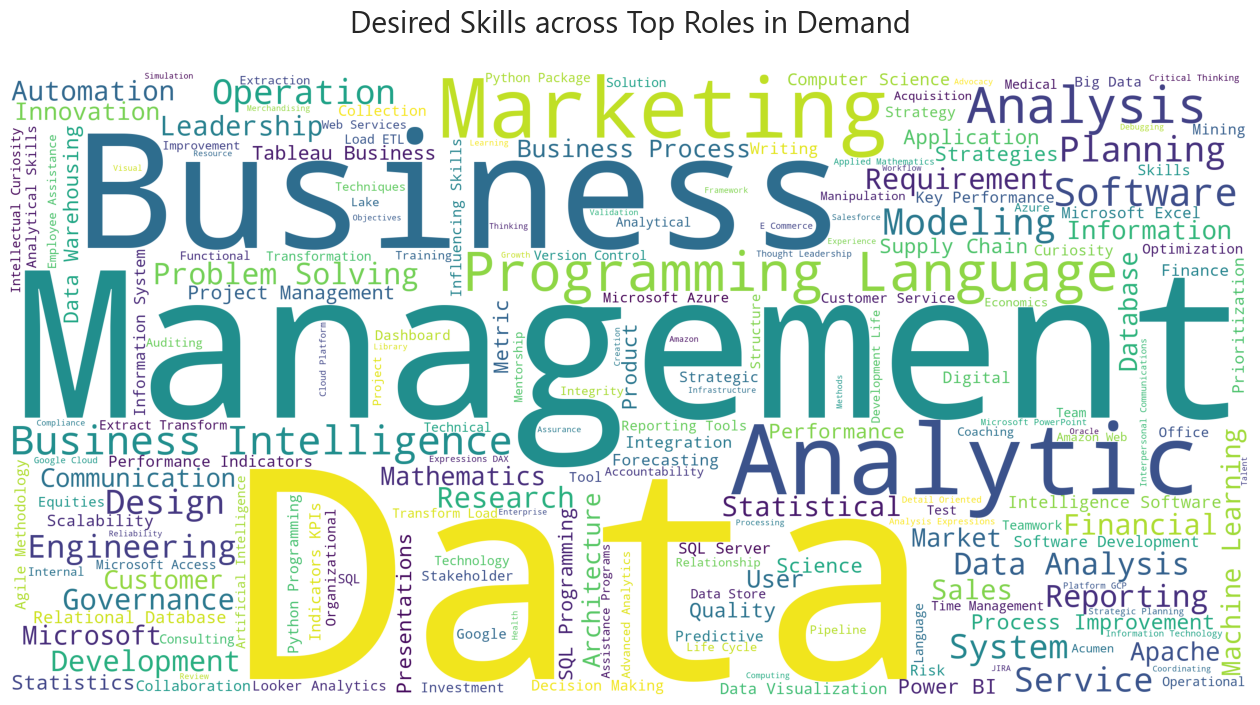

: 

In [113]:
# wordcloud of skills across top data roles
plt.figure(figsize=(16,9))
text = skillsdf.Skill.str.cat(sep=' ')
ax = WordCloud(width=2800, height=1200, background_color='white').generate(text)
plt.axis('off')
plt.title('Desired Skills across Top Roles in Demand', y=1.05)
plt.imshow(ax)

5. Salary range

In [22]:
# extract salary from job description
# define function to extract salary
def salary(text):
    salary = re.search('\$\d+\,\d+ - \$\d+\,\d+', text)
    if salary is not None:
        return salary.group(0)

data['desc2'] = data['desc2'].astype('str') 
data['salary'] = data['desc2'].apply(salary)
data['salary'] = data['salary'].str.replace('$', '') # remove $ sign
data['salary'] = data['salary'].str.replace(',', '')
data[['lower', 'upper']] = data['salary'].str.split(' - ', expand=True)

# convert to int data type
data['lower'] = data['lower'].astype('Int64')
data['upper'] = data['upper'].astype('Int64')


In [38]:
# clean typo in salary
salarydata = data.dropna(subset='salary')
salarydata['range'] = salarydata['upper'] - salarydata['lower']
salarydata[salarydata['range'] < 0]
salarydata.loc[911, 'upper'] = 191000

C:\Users\vanvi\AppData\Local\Temp\ipykernel_27568\2148482857.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



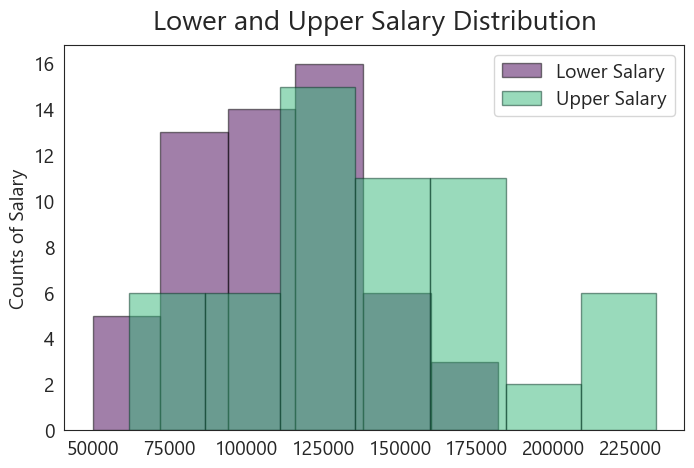

In [102]:
# histogram of salary
remotedata = salarydata[salarydata['workmode'] == 'Remote']

plt.figure(figsize=(8,5))

remotedata['lower'].plot(kind='hist', alpha=0.5, color='#440154', edgecolor = '#000000', label='Lower Salary', bins=6)
remotedata['upper'].plot(kind='hist', alpha=0.5, color='#35b779', edgecolor = '#013220', label='Upper Salary', bins=7)
plt.title('Lower and Upper Salary Distribution', fontsize=20, fontname='Segoe UI', y=1.02)
plt.ylabel('Counts of Salary', fontsize=14, fontname='Segoe UI')
plt.legend(fontsize=14)
plt.show()